In [179]:
# Imports from Pyomo, including "value" for getting the value of Pyomo objects
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Objective, Expression, value

#import flowsheet block from IDAES core
from idaes.core import FlowsheetBlock

#import function to link units in a flowsheet
from pyomo.network import Arc

#import function to get default solver
from watertap.core.solvers import get_solver

#import function to check degrees of freedom
from idaes.core.util.model_statistics import degrees_of_freedom

#import utility function for calculating scaling factors
from idaes.core.util.scaling import calculate_scaling_factors, set_scaling_factor

#import function to propagate state
from idaes.core.util.initialization import propagate_state

#import property model
from watertap.property_models.unit_specific.dioxane_prop_pack import DioxaneParameterBlock
from watertap.property_models.unit_specific.NDMA_prop_pack import NDMAParameterBlock

#import costing model
from watertap.costing import WaterTAPCosting
from idaes.core import UnitModelCostingBlock

In [180]:
def basic_uv_aop_setup(m, reactor_num, tea_scenario, lamp_type, contaminant_type, dose_override=None):
    """Function that sets up a basic UV-AOP reactor model based on user inputs
    Args: 
        m (ConcreteModel): Pyomo concrete model to which the UV-AOP unit model will be added
        reactor_num (int): reactor identification number, used to track multiple reactors in series
        tea_scenario (int): scenario for the model, options include 1 (0 mg/L H2O2), 2 (3 mg/L H2O2), 3 (6 mg/L H2O2), or 4 (9 mg/L H2O2)
        lamp_type (str): type of UV lamp used, either 'LPUV' (low-pressure mercury lamp, 254-nm) or 'KrCl*' (krypton chloride excimer lamp, 222-nm)
        contaminant_type (str): type of contaminant being treated, either '1,4-dioxane' or 'NDMA'
        dose_override (float, optional): UV dose [J/m2] to override default dose for each scenario. Optional argument that defaults to None.
    Returns:
        m (ConcreteModel): Pyomo concrete model with added UV AOP unit model
        total_dose (float): Target UV dose [J/m2] required for 0.5 log removal of 1,4-dioxane
    """
    #name the reactor based on its ID number
    reactor_name = f"unit_{reactor_num}"

    #import UV-AOP model for specified lamp type
    if lamp_type == 'LPUV':
        from watertap.unit_models.uv_aop_viqua import (Ultraviolet0D, MaterialBalanceType, EnergyBalanceType, MomentumBalanceType, UVDoseType, useDefault)
    elif lamp_type == 'KrCl*':
        from watertap.unit_models.uv_aop_KrCl import (Ultraviolet0D, MaterialBalanceType, EnergyBalanceType, MomentumBalanceType, UVDoseType, useDefault)

    #add an UV-AOP unit to the flowsheet; note, AOP is marked false in all scenarios to circumvent the need for developing indirect/direct photoloysis rate constants
    setattr(m.fs, reactor_name, Ultraviolet0D(
        dynamic=False,
        has_holdup=False,
        material_balance_type=MaterialBalanceType.useDefault,
        energy_balance_type=EnergyBalanceType.useDefault,
        momentum_balance_type=MomentumBalanceType.pressureTotal,
        property_package=m.fs.properties,
        has_pressure_change=False,
        uv_dose_type=UVDoseType.fixed,
        has_aop=False,
        target_species=None
    ))

    #access the newly created unit using the dynamic name
    reactor = getattr(m.fs, reactor_name)

    #specify feedstate variables
    flow_rate = 163.2/24/60/60 #[m3/s], based capacity of low-pressure mercury UV lamp used in Project 1550
    reactor_volume = 0.0081 #[m3], based on volume of UV reactor used in Project 1550
    reactor.inlet.temperature.fix(273.15 + 25) #temperature at inlet [degrees K]
    reactor.inlet.pressure.fix(101325) #pressure at inlet [Pa]
    reactor.outlet.pressure.fix(101325) #pressure at outlet [Pa]
    reactor.inlet.flow_mass_phase_comp[0, 'Liq', 'H2O'].fix(flow_rate*1000) #mass flow rate of water [kg/s]

    #specify basic uv model parameters based target contaminant, lamp type, and TEA scenario for 0.5 log reduction of 1,4-dioxane (0.5 log reduction = 68.4% removal)
    if contaminant_type == '1,4-dioxane':
        if reactor_num == 1: 
            reactor.inlet.flow_mass_phase_comp[0, "Liq", "Dioxane"].fix(influent_cnc*1000*flow_rate/(10**6)/1000) #mass flow rate of 1,4-dioxane [kg/s]

        if lamp_type == 'LPUV': 
            reactor.lamp_efficiency.fix(0.375) #lamp efficiency [%]; how much power is converted to usable UV radiation
            match tea_scenario:
                case 1:
                    total_dose = 173920 #total UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 0 mg/L H2O2
                    reactor.inactivation_rate.fix(6.61e-6) #overall inactivation rate constant [m2/J]; represents combined degredation from direct and indirect photolysis
                case 2:
                    total_dose = 39390 #total UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 0 mg/L H2O2
                    reactor.inactivation_rate.fix(2.92e-5) #overall inactivation rate constant [m2/J]; represents combined degredation from direct and indirect photolysis
                case 3:
                    total_dose = 22320 #total UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 0 mg/L H2O2
                    reactor.inactivation_rate.fix(5.15e-5) #overall inactivation rate constant [m2/J]; represents combined degredation from direct and indirect photolysis
                case 4:
                    total_dose = 16690 #total UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 0 mg/L H2O2
                    reactor.inactivation_rate.fix(6.89e-5) #overall inactivation rate constant [m2/J]; represents combined degredation from direct and indirect photolysis
            reactor.uv_dose.fix(total_dose) #UV dose [J/m^2]

        elif lamp_type == 'KrCl*': 
            reactor.lamp_efficiency.fix(0.06) #lamp efficiency [%]; how much power is converted to usable UV radiation
            match tea_scenario:
                case 1:
                    total_dose = 6630 #total UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 0 mg/L H2O2
                    reactor.inactivation_rate.fix(1.73e-4) #overall inactivation rate constant [m2/J]; represents combined degredation from direct and indirect photolysis
                case 2:
                    total_dose = 5460 #total UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 0 mg/L H2O2
                    reactor.inactivation_rate.fix(2.11e-4) #overall inactivation rate constant [m2/J]; represents combined degredation from direct and indirect photolysis
                case 3:
                    total_dose = 5640 #total UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 0 mg/L H2O2
                    reactor.inactivation_rate.fix(2.04e-4) #overall inactivation rate constant [m2/J]; represents combined degredation from direct and indirect photolysis
                case 4:
                    total_dose = 4700 #total UV dose [J/m2] needed for 0.5 log removal of 1,4-dioxane at 0 mg/L H2O2
                    reactor.inactivation_rate.fix(2.45e-4) #overall inactivation rate constant [m2/J]; represents combined degredation from direct and indirect photolysis            
            reactor.uv_dose.fix(total_dose) #UV dose [J/m^2]

    elif contaminant_type == 'NDMA':  
        if reactor_num == 1:
            reactor.inlet.flow_mass_phase_comp[0, "Liq", "NDMA"].fix(influent_cnc*1000*flow_rate/(10**6)/1000) #mass flow rate of NDMA [kg/s]
        if lamp_type == 'LPUV': 
            reactor.lamp_efficiency.fix(0.375) #lamp efficiency [%]; how much power is converted to usable UV radiation
            reactor.inactivation_rate.fix(2.29*(10**-3)) #overall inactivation rate constant [m2/J]; degredation is primarily driven by direct photolysis for NDMA
            match tea_scenario:
                case 1:
                    total_dose = 173920 #total UV dose [J/m2] needed for 0.5 log removal of NDMA at 0 mg/L H2O2
                case 2:
                    total_dose = 39390 #total UV dose [J/m2] needed for 0.5 log removal of NDMA at 0 mg/L H2O2
                case 3:
                    total_dose = 22320 #total UV dose [J/m2] needed for 0.5 log removal of NDMA at 0 mg/L H2O2
                case 4:
                    total_dose = 16690 #total UV dose [J/m2] needed for 0.5 log removal of NDMA at 0 mg/L H2O2
            reactor.uv_dose.fix(total_dose) #UV dose [J/m^2]

        elif lamp_type == 'KrCl*':
            reactor.lamp_efficiency.fix(0.06) #lamp efficiency [%]; how much power is converted to usable UV radiation
            reactor.inactivation_rate.fix(3.9*(10**-4)) #overall inactivation rate constant [m2/J]; degredation is primarily driven by direct photolysis for NDMA
            match tea_scenario: #assume same rated dose of 400 J/m2 for KrCl* lamp
                case 1:
                    total_dose = 6630 #total UV dose [J/m2] needed for 0.5 log removal of NDMA at 0 mg/L H2O2
                case 2:
                    total_dose = 5460 #total UV dose [J/m2] needed for 0.5 log removal of NDMA at 0 mg/L H2O2
                case 3:
                    total_dose = 5640 #total UV dose [J/m2] needed for 0.5 log removal of NDMA at 0 mg/L H2O2
                case 4:
                    total_dose = 4700 #total UV dose [J/m2] needed for 0.5 log removal of NDMA at 0 mg/L H2O2
            reactor.uv_dose.fix(total_dose) #UV dose [J/m^2]

    #override uv dose to the maximum possible output of the lamp; this option should be toggled on when analyzing multiple reactors in series
    if dose_override != None:
        reactor.uv_dose.fix(dose_override) #UV dose [J/m^2]              

    #back-calculate key variables based on user inputs
    reactor.exposure_time.fix(reactor_volume/flow_rate) #exposure time [s]
    reactor.electricity_demand.fix((value(reactor.uv_dose)/value(reactor.lamp_efficiency))*(0.103)/value(reactor.exposure_time)) #electricity demand [W]

    #fix additional parameter for multiple reactors in series
    if reactor_num > 1:
        reactor.uv_intensity.fix(value(reactor.uv_dose)/value(reactor.exposure_time)) #UV intensity [J/m2/s]

    return m, total_dose

In [187]:
def build_model(tea_scenario, lamp_type, contaminant_type, multiple_reactors, dose_override = None):
    """Function that builds a Pyomo model for UV-AOP treatment of 1,4-dioxane and N-nitrosodimethylamine (NDMA) in greywater
    Args:
        tea_scenario (int): scenario for the model, options include 1 (0 mg/L H2O2), 2 (3 mg/L H2O2), 3 (6 mg/L H2O2), or 4 (9 mg/L H2O2)
        lamp_type (str): type of UV lamp used, either 'LPUV' (low-pressure mercury lamp, 254-nm) or 'KrCl*' (krypton chloride excimer lamp, 222-nm)
        contaminant_type (str): type of contaminant being treated, either '1,4-dioxane' or 'NDMA'
        multiple_reactors (bool): whether to model multiple reactors in series to achieve target log removal.
        dose_override (float, optional): UV dose [J/m2] to override default dose for each scenario. Optional argument that defaults to None.
    Returns:
        m (ConcreteModel): Pyomo model.
        log_removal (float): Log removal of NDMA.    
    """
    #create a Pyomo concrete model
    m = ConcreteModel()

    #add flowsheet block to the model
    m.fs = FlowsheetBlock(dynamic=False)

    #add property parameter block to the flowsheet based on target contaminant
    if contaminant_type == '1,4-dioxane':
        m.fs.properties = DioxaneParameterBlock()
        influent_cnc = 15 #concentration of 1,4-dioxane [micrograms/L] entering UV AOP reactor
    elif contaminant_type == 'NDMA':  
        m.fs.properties = NDMAParameterBlock()
        influent_cnc = 0.041 #concentration of NDMA [micrograms/L] entering UV AOP reactor
           
    #add costing block to the flowsheet
    m.fs.costing = WaterTAPCosting() 

    #add UV-AOP reactors to the flowsheet based on whether user requests multiple reactors in series
    if multiple_reactors == True:
        dose_override = 400 #maximum UV dose per reactor [J/m2] for low-pressure mercury lamps (based on VIQUA PRO 30)
        #add first reactor to the flowsheet
        m, target_dose = basic_uv_aop_setup(m, 1, tea_scenario, lamp_type, contaminant_type, dose_override)
        #calculate number of reactors needed in series to achieve target dose
        num_reactors = pyo.ceil(target_dose/value(m.fs.unit_1.uv_dose)) #number of reactors in series needed to achieve target dose
        print(f"Number of reactors in series: {num_reactors}")
        #add additional UV reactors in series and link them together
        for i in range(2, int(num_reactors) + 1):
            m, target_dose = basic_uv_aop_setup(m, i, tea_scenario, lamp_type, contaminant_type, dose_override)
            reactor_1 = getattr(m.fs, f"unit_{i-1}")
            reactor_2 = getattr(m.fs, f"unit_{i}")
            setattr(m.fs, f"stream_{i}", Arc(source = reactor_1.outlet, destination = reactor_2.inlet))
        pyo.TransformationFactory("network.expand_arcs").apply_to(m)    
    else:
        #add first reactor to the flowsheet
        m, target_dose = basic_uv_aop_setup(m, 1, tea_scenario, lamp_type, contaminant_type)
        num_reactors = 1
    
    #add costing for each UV-AOP reactor
    for i in range(1, num_reactors + 1):
        reactor = getattr(m.fs, f"unit_{i}")
        reactor.costing = UnitModelCostingBlock(
            flowsheet_costing_block=m.fs.costing
        )

    #add system costing (capital and operating costs) based on lamp type
    m.fs.costing.cost_process()
    m.fs.costing.add_annual_water_production(m.fs.unit_1.control_volume.properties_in[0].flow_vol)
    m.fs.costing.add_specific_energy_consumption(m.fs.unit_1.control_volume.properties_in[0].flow_vol)
    m.fs.costing.add_LCOW(m.fs.unit_1.control_volume.properties_in[0].flow_vol)

    #add expressions to separate capital and operating contributions to LCOW
    m.fs.costing.LCOW_capex = pyo.Expression(
        expr=(
            m.fs.costing.total_capital_cost * m.fs.costing.capital_recovery_factor
        ) / (
            pyo.units.convert(
                m.fs.unit_1.control_volume.properties_in[0].flow_vol,
                to_units=pyo.units.m**3 / m.fs.costing.base_period
            ) * m.fs.costing.utilization_factor
        ),
        doc="LCOW contribution from capital expenses"
    )

    m.fs.costing.LCOW_opex = pyo.Expression(
        expr=(
            m.fs.costing.total_operating_cost
        ) / (
            pyo.units.convert(
                m.fs.unit_1.control_volume.properties_in[0].flow_vol,
                to_units=pyo.units.m**3 / m.fs.costing.base_period
            ) * m.fs.costing.utilization_factor
        ),
        doc="LCOW contribution from operating expenses"
    )

    #calculate scaling factors
    calculate_scaling_factors(m.fs)

    #check that degrees of freedom is zero
    assert(degrees_of_freedom(m.fs) == 0), "Degrees of freedom = " + str(degrees_of_freedom(m.fs))

    #setup solver
    solver = get_solver()

    #initialize each reactor in the baseline model
    for i in range(1, num_reactors + 1):
        if num_reactors > 1:
            stream = getattr(m.fs, f"stream_{i}")
            propagate_state(stream)
        reactor = getattr(m.fs, f"unit_{i}")
        reactor.initialize()

    # initialize cost
    m.fs.costing.initialize()

    #solve model
    simulation_results = solver.solve(m)

    #calculate log removal of NDMA
    if contaminant_type == 'NDMA':
        log_removal = -pyo.log10(value(m.fs.unit_1.outlet.flow_mass_phase_comp[0, "Liq", "NDMA"]) / value(m.fs.unit_1.inlet.flow_mass_phase_comp[0, "Liq", "NDMA"]))
    else:
        log_removal = None    

    return m, log_removal, num_reactors

In [188]:
#create dataframe to store LCOW results for each baseline scenario
import pandas as pd
base_diox_LCOW = pd.DataFrame(columns=['tea_scenario', 'H2O2 cnc', 'lamp_type', 'LCOW', 'specific_energy_consumption', 'LCOW_capex', 'LCOW_opex'])
base_ndma_LCOW = pd.DataFrame(columns=['tea_scenario', 'H2O2 cnc', 'lamp_type', 'LCOW', 'specific_energy_consumption', 'LCOW_capex', 'LCOW_opex', 'log_removal'])

#iterate through contaminants, TEA scenarios, and lamp types
for contaminant in ['1,4-dioxane', 'NDMA']:
    for tea_scenario in [1, 2, 3, 4]:
        for lamp_type in ['LPUV', 'KrCl*']:
            if contaminant == '1,4-dioxane':
                #solve baseline model
                m, log_removal, num_reactors = build_model(tea_scenario, lamp_type, contaminant, True, dose_override = 400)
                #add LCOW to dataframe for comparing scenarios
                match tea_scenario:
                    case 1:
                        h202 = 0
                    case 2:
                        h202 = 3
                    case 3:
                        h202 = 6
                    case 4:
                        h202 = 9

                base_diox_LCOW.loc[len(base_diox_LCOW)] = [
                    tea_scenario,
                    h202,
                    lamp_type,
                    value(m.fs.costing.LCOW),
                    value(m.fs.costing.specific_energy_consumption),
                    value(m.fs.costing.LCOW_capex),
                    value(m.fs.costing.LCOW_opex)
                ]
            elif contaminant == 'NDMA':
                #solve baseline model
                m, log_removal, num_reactors = build_model(tea_scenario, lamp_type, contaminant, True, dose_override = 400)
                #add LCOW to dataframe for comparing scenarios
                match tea_scenario:
                    case 1:
                        h202 = 0
                    case 2:
                        h202 = 3
                    case 3:
                        h202 = 6
                    case 4:
                        h202 = 9

                base_ndma_LCOW.loc[len(base_ndma_LCOW)] = [
                    tea_scenario,
                    h202,
                    lamp_type,
                    value(m.fs.costing.LCOW),
                    value(m.fs.costing.specific_energy_consumption),
                    value(m.fs.costing.LCOW_capex),
                    value(m.fs.costing.LCOW_opex),
                    log_removal
                ]    

Number of reactors in series: 435
2025-10-13 14:51:02 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,H2O]
2025-10-13 14:51:02 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,Dioxane]
2025-10-13 14:51:02 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,H2O]
2025-10-13 14:51:02 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,Dioxane]
2025-10-13 14:51:02 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.uv_intensity
2025-10-13 14:51:02 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.exposure_time
2025-10-13 14:51:02 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit_1.uv_dose
2025-10-13 14:51:02 [

AssertionError: Degrees of freedom = -1736

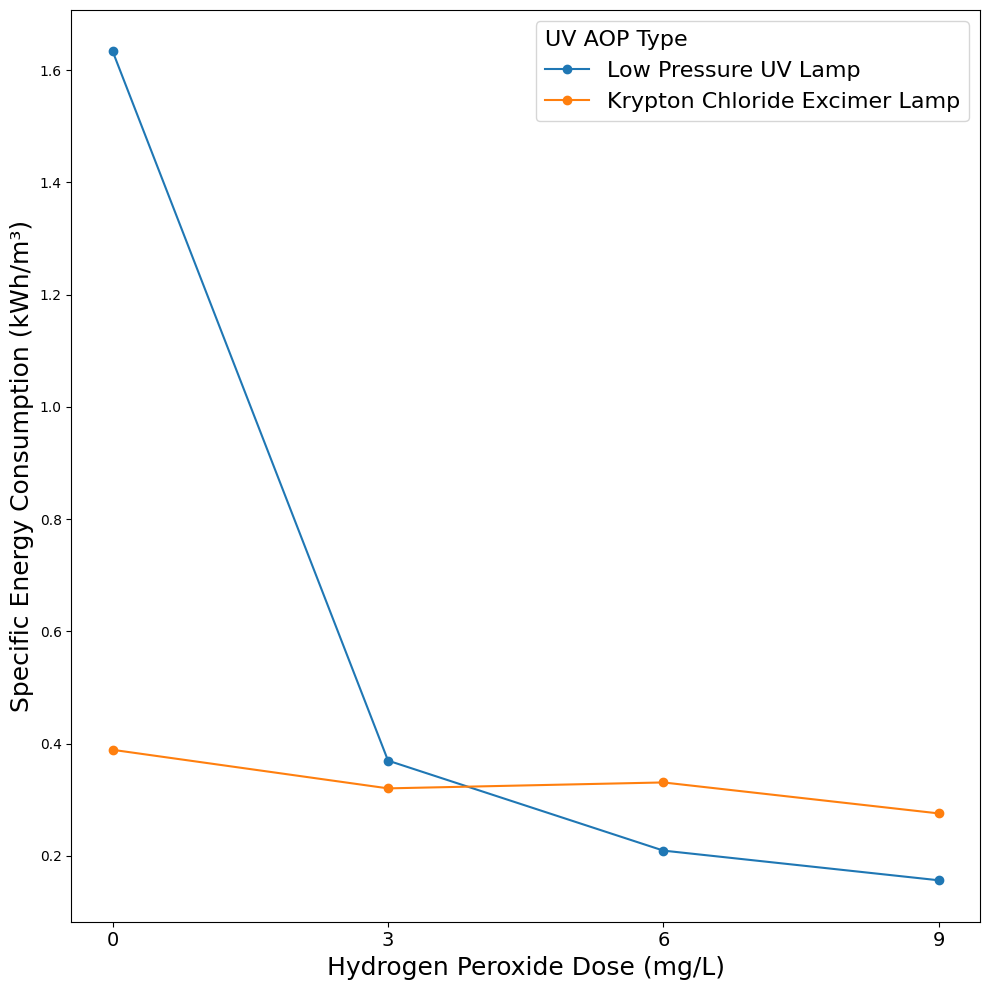

In [67]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

#create plot of specific energy consumption vs hydrogen peroxide dose for each lamp type (fig. 1a)
fig, ax = plt.subplots(figsize=(10, 10), sharex=True)

subset = base_diox_LCOW[base_diox_LCOW['lamp_type'] == 'LPUV']
ax.plot(subset['H2O2 cnc'], subset['specific_energy_consumption'], marker='o', label='Low Pressure UV Lamp')

subset = base_diox_LCOW[base_diox_LCOW['lamp_type'] == 'KrCl*']
ax.plot(subset['H2O2 cnc'], subset['specific_energy_consumption'], marker='o', label='Krypton Chloride Excimer Lamp')

ax.set_ylabel('Specific Energy Consumption (kWh/m³)', fontsize=18)
ax.set_xlabel('Hydrogen Peroxide Dose (mg/L)', fontsize=18)
ax.grid(False)
ax.legend(title="UV AOP Type", fontsize=16, title_fontsize=16, alignment ='left')
ax.set_xticks([0, 3, 6, 9])
ax.set_xticklabels([0, 3, 6, 9], fontsize=14)
plt.tight_layout()
plt.savefig('figure_1a.jpeg', bbox_inches='tight')
plt.show()

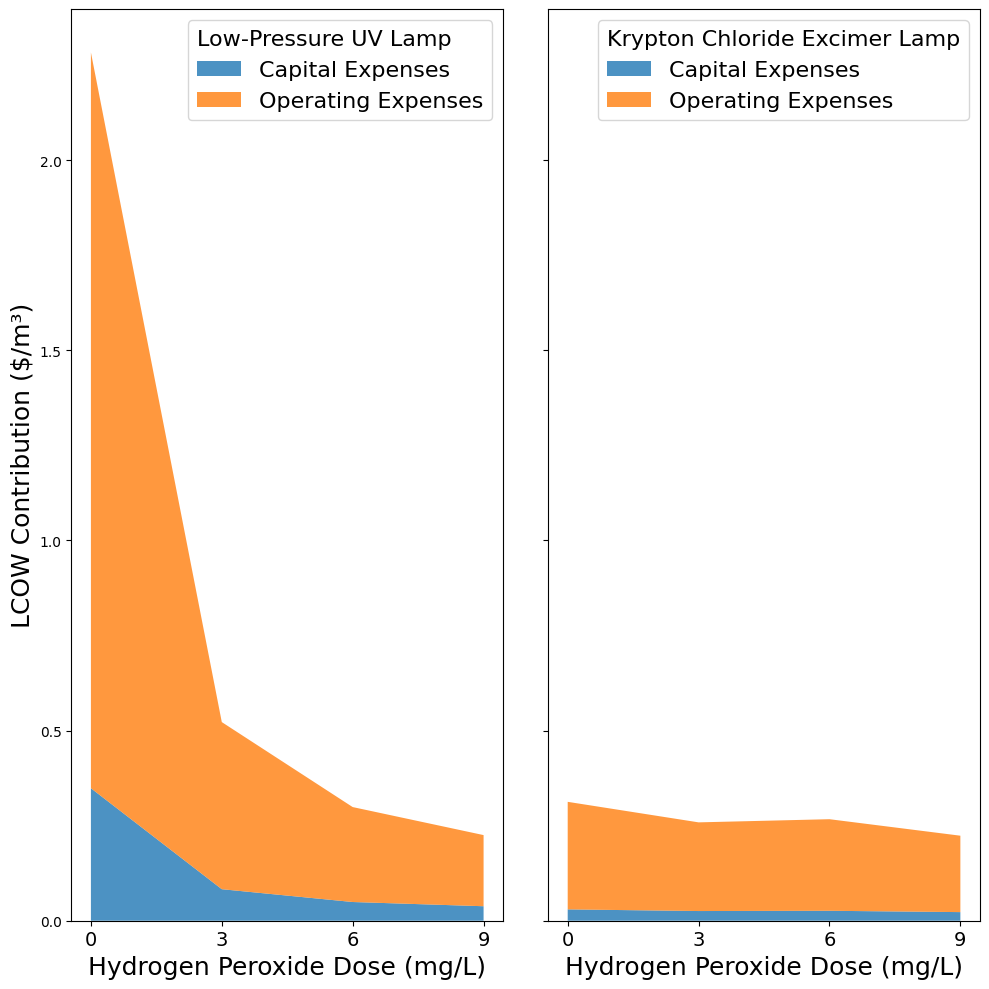

In [68]:
#create plot of CAPEX and OPEX vs hydrogen peroxide dose for each lamp type (fig 1b and c)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10), sharex=True, sharey=True)

#LPUV lamp
subset = base_diox_LCOW[base_diox_LCOW['lamp_type'] == 'LPUV']
h2o2_dose = subset['H2O2 cnc']
capex = subset['LCOW_capex']
opex = subset['LCOW_opex']
ax1.stackplot(h2o2_dose, capex, opex, labels=['Capital Expenses', 'Operating Expenses'], alpha=0.8)

#KrCl* lamp
subset = base_diox_LCOW[base_diox_LCOW['lamp_type'] == 'KrCl*']
h2o2_dose = subset['H2O2 cnc']
capex = subset['LCOW_capex']
opex = subset['LCOW_opex']
ax2.stackplot(h2o2_dose, capex, opex, labels=['Capital Expenses', 'Operating Expenses'], alpha=0.8)

#formatting
ax1.set_xlabel('Hydrogen Peroxide Dose (mg/L)', fontsize=18)
ax2.set_xlabel('Hydrogen Peroxide Dose (mg/L)', fontsize=18)
ax1.set_ylabel('LCOW Contribution ($/m³)', fontsize=18)
ax1.grid(False)
ax1.legend(title="Low-Pressure UV Lamp", fontsize=16, title_fontsize=16, alignment ='left')
ax2.legend(title="Krypton Chloride Excimer Lamp", fontsize=16, title_fontsize=16, alignment ='left')
ax1.set_xticks([0, 3, 6, 9])
ax1.set_xticklabels([0, 3, 6, 9], fontsize=14)
ax2.set_xticks([0, 3, 6, 9])
ax2.set_xticklabels([0, 3, 6, 9], fontsize=14)
plt.tight_layout()
plt.savefig('figure_1b_c.jpeg', bbox_inches='tight')
plt.show()

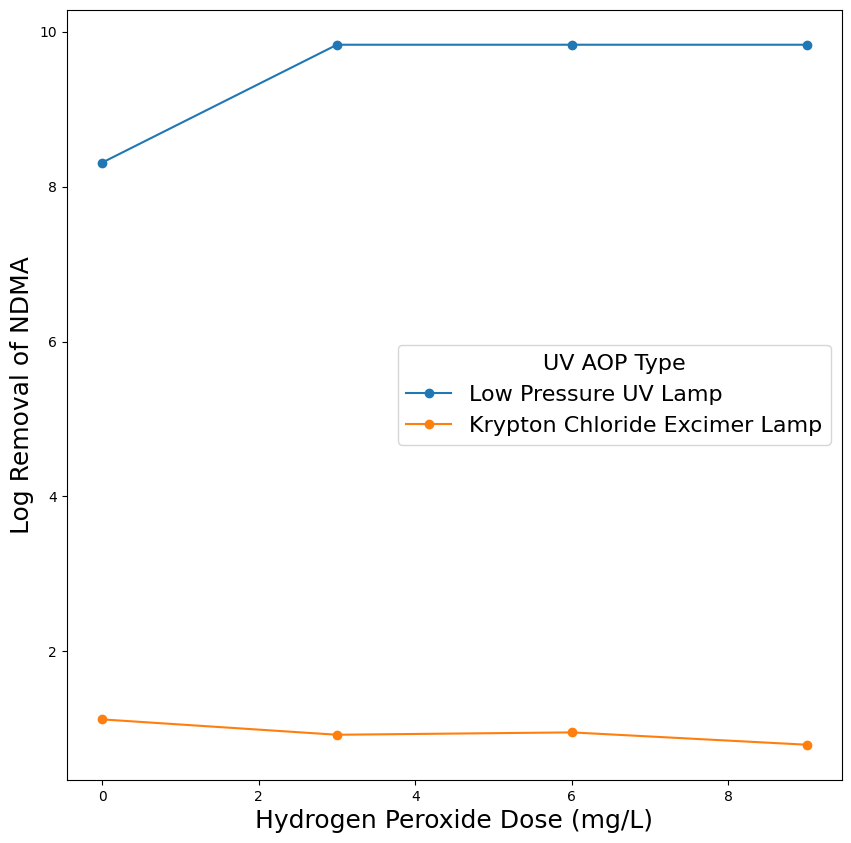

In [57]:
#create plot of log removal vs hydrogen peroxide dose for each lamp type
fig, ax = plt.subplots(figsize=(10, 10), sharex=True)
subset = base_ndma_LCOW[base_ndma_LCOW['lamp_type'] == 'LPUV']
ax.plot(subset['H2O2 cnc'], subset['log_removal'], marker='o', label='Low Pressure UV Lamp')

subset = base_ndma_LCOW[base_ndma_LCOW['lamp_type'] == 'KrCl*']
ax.plot(subset['H2O2 cnc'], subset['log_removal'], marker='o', label='Krypton Chloride Excimer Lamp')

ax.set_ylabel('Log Removal of NDMA', fontsize=18)
ax.set_xlabel('Hydrogen Peroxide Dose (mg/L)', fontsize=18)
ax.grid(False)
ax.legend(title="UV AOP Type", fontsize=16, title_fontsize=16)

In [59]:
print('Average LPUV NDMA log reduction: ' + str(base_ndma_LCOW.loc[base_ndma_LCOW['lamp_type'] == 'LPUV', 'log_removal'].mean()))
print('Average LPUV NDMA log reduction: ' + str(base_ndma_LCOW.loc[base_ndma_LCOW['lamp_type'] == 'KrCl*', 'log_removal'].mean()))

Average LPUV NDMA log reduction: 6.88730486888873
Average LPUV NDMA log reduction: 0.9497692427526713


2025-10-03 14:06:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,H2O]
2025-10-03 14:06:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,NDMA]
2025-10-03 14:06:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,H2O]
2025-10-03 14:06:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,NDMA]
2025-10-03 14:06:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.uv_intensity
2025-10-03 14:06:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.exposure_time
2025-10-03 14:06:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.uv_dose
2025-10-03 14:06:23 [WARNING] idaes.core.util.scaling: Missing scaling fact

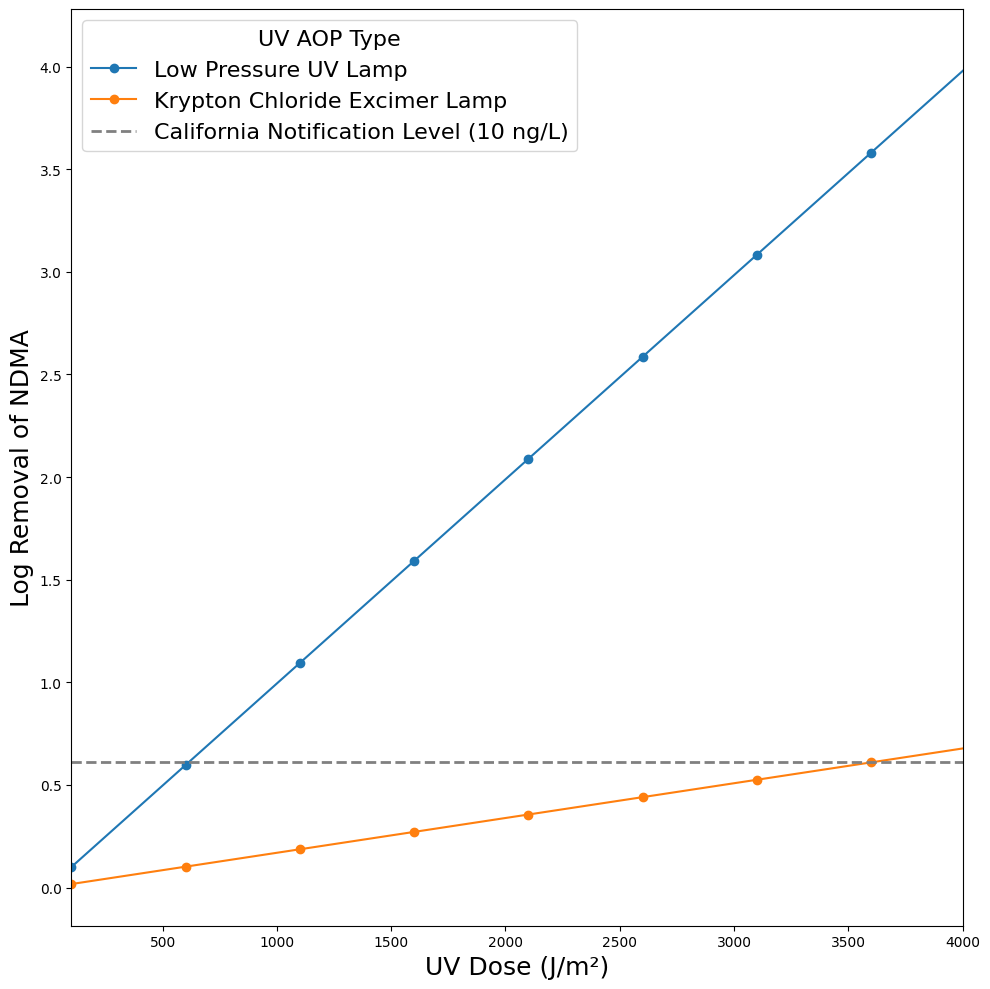

In [63]:
#initialize dataframe to hold UV dose vs log removal of NDMA data for each lamp type
base_ndma_lr = pd.DataFrame(columns=['lamp_type', 'log_removal', 'uv_dose','LCOW', 'specific_energy_consumption','LCOW_capex', 'LCOW_opex'])

#initialize baseline model for NDMA degradation by both lamp types
for lamp_type in ['LPUV', 'KrCl*']:
    #set lower and upper bounds for UV dose [J/m^2]
    lower_bound = 100
    upper_bound = 4500

    #solve baseline model at different UV doses to generate UV dose vs log removal curve
    for dose in range(lower_bound, upper_bound+1, 500):
        m, log_removal = build_model(1, lamp_type, contaminant_type = 'NDMA', dose_override = dose)

        #add UV dose vs log removal data to dataframe for comparing scenarios
        base_ndma_lr.loc[len(base_ndma_lr)] = [
            lamp_type,
            log_removal,
            dose,
            value(m.fs.costing.LCOW),
            value(m.fs.costing.specific_energy_consumption),
            value(m.fs.costing.LCOW_capex),
            value(m.fs.costing.LCOW_opex)
        ]

#create plot of UV dose vs NDMA log removal for each lamp type (Figure 2)
fig, ax = plt.subplots(figsize=(10, 10), sharex=True)
subset = base_ndma_lr[base_ndma_lr['lamp_type'] == 'LPUV']
ax.plot(subset['uv_dose'], subset['log_removal'], marker='o', label='Low Pressure UV Lamp')

subset = base_ndma_lr[base_ndma_lr['lamp_type'] == 'KrCl*']
ax.plot(subset['uv_dose'], subset['log_removal'], marker='o', label='Krypton Chloride Excimer Lamp')

ax.set_ylabel('Log Removal of NDMA', fontsize=18)
ax.set_xlabel('UV Dose (J/m²)', fontsize=18)
ax.grid(False)
ax.legend(title="UV AOP Type", fontsize=16, title_fontsize=16)

#set limits for x axis
ax.set_xlim([lower_bound, 4000])

#add horizontal line for 0.613 log removal (reduces NDMA concentration to 10 ng/L, the California notification limit)
ax.plot([lower_bound, upper_bound], [0.613, 0.613], color='gray', linestyle='--', linewidth=2)

#add 0.613 log removal line to legend
line = mlines.Line2D([], [], color='gray', linestyle='--', linewidth=2, label='California Notification Level (10 ng/L)')
ax.legend(handles=ax.get_legend_handles_labels()[0] + [line], labels=ax.get_legend_handles_labels()[1] + ['California Notification Level (10 ng/L)'], title="UV AOP Type", fontsize=16, title_fontsize=16)

#export figure
plt.tight_layout()
plt.savefig('figure_2.jpeg', bbox_inches='tight')
plt.show()


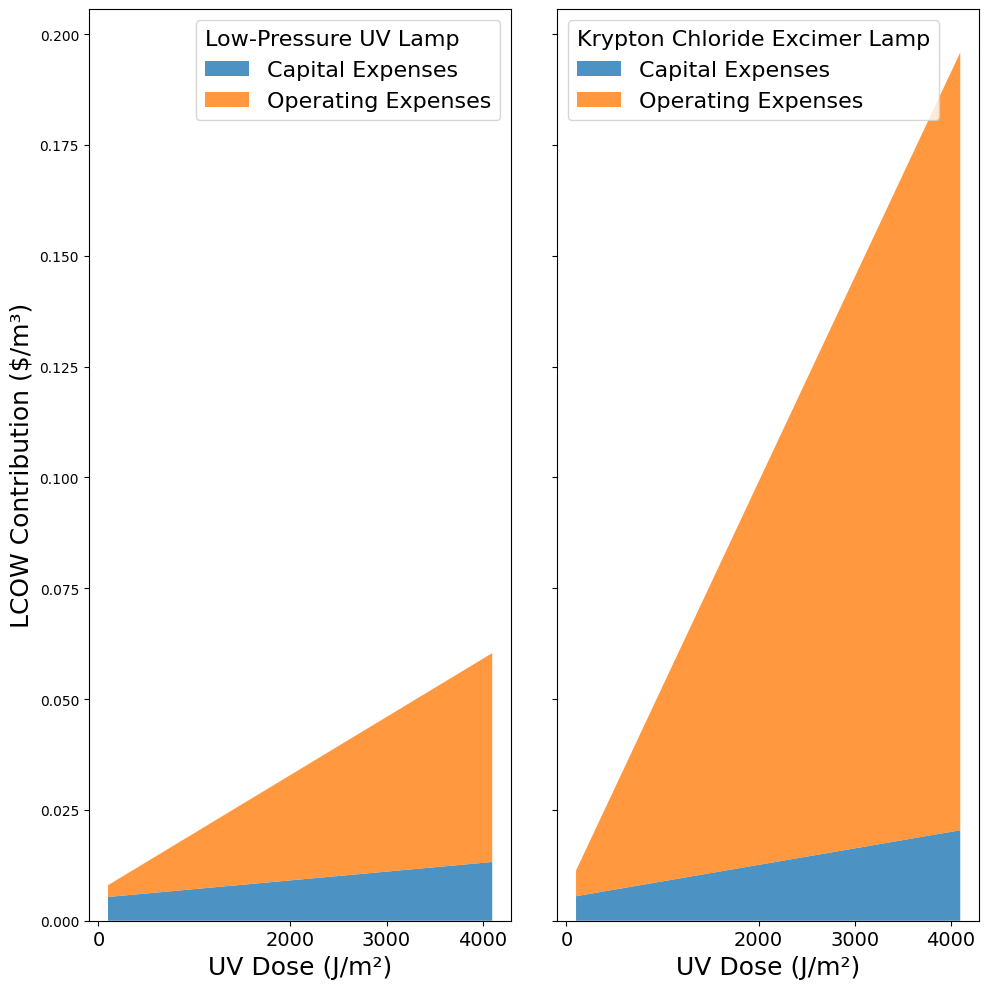

In [ ]:
#create plot of CAPEX and OPEX vs UV dose for each lamp type (fig 2b and c)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10), sharex=True, sharey=True)

#LPUV lamp
subset = base_ndma_lr[base_ndma_lr['lamp_type'] == 'LPUV']
uv_dose = subset['uv_dose']
capex = subset['LCOW_capex']
opex = subset['LCOW_opex']
ax1.stackplot(uv_dose, capex, opex, labels=['Capital Expenses', 'Operating Expenses'], alpha=0.8)

#KrCl* lamp
subset = base_ndma_lr[base_ndma_lr['lamp_type'] == 'KrCl*']
uv_dose = subset['uv_dose']
capex = subset['LCOW_capex']
opex = subset['LCOW_opex']
ax2.stackplot(uv_dose, capex, opex, labels=['Capital Expenses', 'Operating Expenses'], alpha=0.8)

#formatting
ax1.set_xlabel('UV Dose (J/m²)', fontsize=18)
ax2.set_xlabel('UV Dose (J/m²)', fontsize=18)
ax1.set_ylabel('LCOW Contribution ($/m³)', fontsize=18)
ax1.grid(False)
ax1.legend(title="Low-Pressure UV Lamp", fontsize=16, title_fontsize=16, alignment ='left')
ax2.legend(title="Krypton Chloride Excimer Lamp", fontsize=16, title_fontsize=16, alignment ='left')
ax1.set_xticks([0, 1000, 2000, 3000, 4000])
ax1.set_xticklabels([0, 2000, 3000, 4000], fontsize=14)
ax2.set_xticks([0, 2000, 3000, 4000])
ax2.set_xticklabels([0, 2000, 3000, 4000], fontsize=14)
plt.tight_layout()
plt.savefig('figure_2b_c.jpeg', bbox_inches='tight')
plt.show()

In [46]:
#import parameter sweep function and LinearSample class
from parameter_sweep import parameter_sweep, LinearSample

def build_sweep_params(model, **kwargs):
    """Define parameters to vary and their ranges."""
    sweep_params = dict()
    # sweep_params['Lamp Efficiency'] = LinearSample(model.fs.unit.lamp_efficiency, 0.05, 1, 10)
    sweep_params['Flow Rate'] = LinearSample(model.fs.unit.inlet.flow_mass_phase_comp[0, 'Liq', 'H2O'], 100, 500, 10)
    sweep_params['Lamp Replacement Factor'] = LinearSample(model.fs.costing.factor_lamp_replacement, 0.1, 2, 10)
    return sweep_params

def build_outputs(model, **kwargs):
    """Define outputs to track."""
    outputs = dict()
    outputs['LCOW'] = model.fs.costing.LCOW
    return outputs

# Run the parameter sweep
parameter_sweep(
    build_model(1, 'LPUV', contaminant_type='1,4-dioxane')[0],
    build_sweep_params,
    build_outputs,
    csv_results_file_name='sensitivity_results.csv',
    h5_results_file_name='sensitivity_results.h5'
)

2025-09-19 15:32:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,H2O]
2025-09-19 15:32:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.control_volume.properties_in[0.0].flow_mass_phase_comp[Liq,Dioxane]
2025-09-19 15:32:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,H2O]
2025-09-19 15:32:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.control_volume.properties_out[0.0].flow_mass_phase_comp[Liq,Dioxane]
2025-09-19 15:32:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.uv_intensity
2025-09-19 15:32:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.exposure_time
2025-09-19 15:32:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.uv_dose
2025-09-19 15:32:36 [WARNING] idaes.core.util.scaling: Missing scalin

AttributeError: '_ScalarWaterTAPCosting' object has no attribute 'factor_lamp_replacement'

In [55]:
m.fs.costing.pprint()

costing : Size=1, Index=None, Active=True
    2 Set Declarations
        flow_types : Size=1, Index=None, Ordered=Insertion
            Key  : Dimen : Domain : Size : Members
            None :     1 :    Any :    1 : {'electricity',}
        used_flows : Size=1, Index=None, Ordered=Insertion
            Key  : Dimen : Domain : Size : Members
            None :     1 :    Any :    1 : {'electricity',}

    17 Var Declarations
        TIC : Total Installed Cost (TIC)
            Size=1, Index=None, Units=dimensionless
            Key  : Lower : Value : Upper : Fixed : Stale : Domain
            None :  None :   2.0 :  None :  True :  True :  Reals
        TPEC : Total Purchased Equipment Cost (TPEC)
            Size=1, Index=None, Units=dimensionless
            Key  : Lower : Value             : Upper : Fixed : Stale : Domain
            None :  None : 4.121212121212121 :  None :  True :  True :  Reals
        aggregate_capital_cost : Size=1, Index=None, Units=USD_2018
            Key 